# Bug In The Code Stack - Experiment w/t LiteLLM (Meta: Llama 3)

# `.env`

- Create a `.env` file with the following info:

```
GROQ_API_KEY=...
```

In [18]:
import pandas as pd

df_ds = pd.read_csv('/Users/acortez/Documents/bug-in-the-code-stack/datasets/bug_in_the_code_stack_alpaca_dataset.csv')
string_columns = df_ds.select_dtypes(include=['object']).columns
df_ds[string_columns] = df_ds[string_columns].fillna('')
df_ds.head()

,output,output_missing_colon,bug_line_number_missing_colon,output_missing_parenthesis,bug_line_number_missing_parenthesis,output_missing_quotation,bug_line_number_missing_quotation,output_missing_comma,bug_line_number_missing_comma,output_mismatched_quotation,bug_line_number_mismatched_quotation,output_mismatched_bracket,bug_line_number_mismatched_bracket,output_keywords_as_identifier,bug_line_number_keywords_as_identifier
0,# Python code\ndef sum_sequence(sequence):\n ...,# Python code\ndef sum_sequence(sequence)\n s...,2,# Python code\ndef sum_sequence(sequence:\n s...,2,,-1,,-1,,-1,# Python code\ndef sum_sequence(sequence]:\n ...,2,# Python code\ndef while(sequence):\n sum = 0...,2
1,"[x*x for x in [1, 2, 3, 5, 8, 13]]",,-1,,-1,,-1,"[x*x for x in [1 2, 3, 5, 8, 13]]",1,,-1,"[x*x for x in [1, 2, 3, 5, 8, 13}]",1,"[for*x for x in [1, 2, 3, 5, 8, 13]]",1
2,def is_palindrome(s):\n '''This function re...,def is_palindrome(s)\n '''This function ret...,1,def is_palindrome(s:\n '''This function ret...,1,def is_palindrome(s):\n ''This function ret...,2,,-1,"def is_palindrome(s):\n '""'This function re...",2,def is_palindrome(s]:\n '''This function re...,1,def if(s):\n '''This function returns True ...,1
3,"def double_add(num1, num2): \n return (num1...",,-1,"def double_add(num1, num2: \n return (num1 ...",1,,-1,def double_add(num1 num2): \n return (num1 ...,1,,-1,"def double_add(num1, num2]: \n return (num1...",1,"def is(num1, num2): \n return (num1 + num2)...",1
4,"def find_numbers_divisible_by(m, n, divisor):\...","def find_numbers_divisible_by(m, n, divisor)\n...",1,"def find_numbers_divisible_by(m, n, divisor:\n...",1,,-1,"def find_numbers_divisible_by(m n, divisor):\n...",1,,-1,"def find_numbers_divisible_by(m, n, divisor}:\...",1,"def not(m, n, divisor):\n divisible_numbers...",1


In [ ]:
!pip install litellm transformers python-dotenv

In [1]:
from abc import ABC, abstractmethod

class Tokenizer(ABC):
    def __init__(self, *args, **kwargs):
        """
        Initialize the Tokenizer with any number of arguments.

        Parameters:
        *args: A tuple of positional arguments.
        **kwargs: A dictionary of keyword arguments.
        """
        # You can handle or pass these arguments as needed
        super().__init__(*args, **kwargs)  # Optional: useful if extending another class with an __init__

    @abstractmethod
    def count_tokens(self, string: str) -> int:
        """
        Abstract method to count tokens in a string.

        Parameters:
        string (str): The string to count tokens in.

        Returns:
        int: The number of tokens.
        """
        pass

In [2]:
from transformers import AutoTokenizer

class LlamaTokenizer(Tokenizer):
  def __init__(self, encoding_name):
    self.encoding_name = encoding_name

  def count_tokens(self, string: str) -> int:
      """Returns the number of tokens in a text string."""
      encoding = AutoTokenizer.from_pretrained(self.encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

/Users/acortez/Documents/bug-in-the-code-stack/bitcs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
tokenizer = LlamaTokenizer('NousResearch/Hermes-3-Llama-3.1-70B')

In [4]:
def number_lines(input_string):
    lines = input_string.splitlines()  # Split the string into lines
    total_lines = len(lines)  # Get the total number of lines to determine the padding width
    max_width = len(str(total_lines))  # Width of the largest line number

    # Enumerate over lines, start counting from 1, and left-align the line numbers
    numbered_lines = [f"{i+1:<{max_width}}| {line}" for i, line in enumerate(lines)]
    # Join the modified lines back into a single string with newlines
    return "\n".join(numbered_lines)

In [5]:
import pandas as pd
import numpy as np

def build_bug_string(df, tokenizer, target_length, target_depth, target_bug):
    selected_strings = []
    total_tokens = 0

    # Randomly select initial strings until target_depth
    while total_tokens < target_length * target_depth:
        row = df['output'].sample().iloc[0]
        selected_strings.append(row)
        total_tokens = tokenizer.count_tokens(number_lines('\n\n'.join(selected_strings)))

    # Remove the last string if we've exceeded the target depth
    if total_tokens > target_length * target_depth:
        selected_strings.pop()
        total_tokens = tokenizer.count_tokens(number_lines('\n\n'.join(selected_strings)))

    # Insert a bug string
    bug_column = f'output_{target_bug}'
    bug_lines_column = f'bug_line_number_{target_bug}'

    # Filter non-empty bug strings and sample one
    bug_df = df[df[bug_column] != ""]
    if bug_df.empty:
        raise ValueError("No entries found for the specified bug type.")
    bug_row = bug_df.sample()
    bug_string = bug_row[bug_column].iloc[0]
    bug_line_number = bug_row[bug_lines_column].iloc[0]
    selected_strings.append(bug_string)
    bug_index = len(selected_strings) - 1  # Index of the bug string in the list

    # Continue adding until just below target_length
    while total_tokens < target_length:
        row = df['output'].sample().iloc[0]
        selected_strings.append(row)
        total_tokens = tokenizer.count_tokens(number_lines('\n\n'.join(selected_strings)))
        if total_tokens >= target_length:
            selected_strings.pop()  # Remove last added string if over limit
            break

    # Concatenate all strings
    result_string = number_lines('\n\n'.join(selected_strings))

    # Calculate bug line number
    result_string_before_bug = number_lines('\n\n'.join(selected_strings[:bug_index]))
    num_lines_before_bug = result_string_before_bug.count('\n')
    bug_line_number_from_start = num_lines_before_bug + bug_line_number
    if len(selected_strings[:bug_index]) > 0:
      bug_line_number_from_start += 2  # Add 2 for the newlines before the string with bug

    return result_string, bug_line_number_from_start, target_bug

> Bug Types

- `missing_colon`
- `missing_parenthesis`
- `missing_quotation`
- `missing_comma`
- `mismatched_quotation`
- `mismatched_bracket`
- `keywords_as_identifier`

In [6]:
background_code, bug_line_number, bug_type = build_bug_string(df_ds, tokenizer, 200, 0.75, 'missing_parenthesis')
print('Auto-Generated Code Background w/t Bug:')
print(background_code)
print()
print('Bug Line Number:')
print(bug_line_number)
print()
print('Bug Type:')
print(bug_type)

NameError: name 'df_ds' is not defined

In [7]:
def generate_prompt(background_code):
  prompt = f"""I will give you a codebase with a syntactic bug hidden at some line. You need to answer the line at which the syntactic error occurs and the type of the syntactic error.

<example>
1 | def fahrenheit_to_celsius(fahrenheit):
2 |   return (fahrenheit - 32) * 5.0/9.0
3 |
4 | def is_prime(num:
5 |     if num <= 1:
6 |         return False
7 |     for i in range(2, int(num**0.5) + 1):
8 |         if num % i == 0:
9 |             return False
10|     return True
Answer: 4, missing_parenthesis
</example>

<example>
1| import random
2| import string
3|
4| def generate_password(length=8):
5|     characters = string.ascii_letters + string.digits
6|     password = '\".join(random.choice(characters) for i in range(length))
7|     return password
Answer: 6, mismatched_quotation
</example>

<context>
{background_code}
</context>

<bug_types>
missing_colon
missing_parenthesis
missing_quotation
missing_comma
mismatched_quotation
mismatched_bracket
keywords_as_identifier
</bug_types>

Always return your answer in the following format: <line_number>, <bug_type>
Do not write anything else after that."""

  return prompt

In [8]:
print(generate_prompt(background_code))

NameError: name 'background_code' is not defined

In [9]:
from abc import ABC, abstractmethod
from typing import Tuple

class Model(ABC):
    def __init__(self, *args, **kwargs):
        """
        Initialize the Tokenizer with any number of arguments.

        Parameters:
        *args: A tuple of positional arguments.
        **kwargs: A dictionary of keyword arguments.
        """
        # You can handle or pass these arguments as needed
        super().__init__(*args, **kwargs)  # Optional: useful if extending another class with an __init__

    @abstractmethod
    def ask_single_bug_test(self, prompt: str) -> Tuple[int, str]:
        """
        Abstract method to ask single bug test to the model.

        Parameters:
        prompt (str): The single bug test prompt.

        Returns:
        int: The line number of the bug.
        str: The type of the bug.
        """
        pass

    @abstractmethod
    def get_context_limit(self) -> int:
        """
        Abstract method to get the context limit of the model.

        Returns:
        int: The context limit.
        """
        pass

In [10]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["DEEPSEEK_API_KEY"] = os.getenv("DEEPSEEK_API_KEY")

In [11]:
from litellm import completion
from typing import Tuple

class DeepseekModel(Model):
    def __init__(self, model_name, context_limit):
      self.model_name = model_name
      self.context_limit = context_limit

    def ask_single_bug_test(self, prompt: str) -> Tuple[int, str]:
      messages = [
          {
              'role': 'system',
              'content': 'You are an intelligent assistant.',
          },
          {
              'role': 'user',
              'content': prompt,
          },
      ]

      response = completion(
          model=self.model_name,
          messages=messages,
      )
      answer = response.choices[0].message.content.strip().lower()

      if answer.endswith('.'):
          answer = answer[:-1]

      line_number, bug_type = answer.split(',')
      line_number = int(line_number.strip())
      bug_type = bug_type.strip()

      return line_number, bug_type

    def get_context_limit(self) -> int:
      return self.context_limit

/Users/acortez/Documents/bug-in-the-code-stack/bitcs/lib/python3.12/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [13]:
model_name = "deepseek/deepseek-coder"
context_limit = 131072

model = DeepseekModel(model_name, context_limit)

In [14]:
from datetime import datetime

def get_unique_time_string():
    current_time = datetime.now()
    return current_time.strftime("%Y%m%d%H%M%S%f")

In [15]:
import os

def create_directory_if_not_exists(path, verbose=False):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
            if verbose:
                print(f"Directory created at: {path}")
        else:
            if verbose:
                print(f"Directory already exists at: {path}")
    except OSError as error:
        if verbose:
            print(f"Error creating directory at {path}: {error}")

In [16]:
import random
import pandas as pd

def single_bug_test(df, tokenizer, model, target_lengths, target_depths, num_iter, verbose=False):
    outfile = f'single_bug_test/result_{get_unique_time_string()}.csv'
    create_directory_if_not_exists('single_bug_test', verbose)

    bug_types = [
        'missing_colon',
        'missing_parenthesis',
        'missing_quotation',
        'missing_comma',
        'mismatched_quotation',
        'mismatched_bracket',
        'keywords_as_identifier'
    ]

    test_no = 1

    df_test_result = pd.DataFrame({
        'target_length': [],
        'target_depth': [],
        'iter_no': [],
        'bug_line_number': [],
        'bug_type': [],
        'pred_bug_line_number': [],
        'pred_bug_type': [],
        'result': [],
    })

    for target_length in target_lengths:
        for target_depth in target_depths:
            i = 0
            while i < num_iter:
                error_count = 0  # Counter for the number of consecutive errors

                while error_count < 3:
                    try:
                        background_code, bug_line_number, bug_type = build_bug_string(df, tokenizer, target_length, target_depth, random.choice(bug_types))
                        prompt = generate_prompt(background_code)
                        prompt_token_count = tokenizer.count_tokens(prompt)

                        if prompt_token_count > model.get_context_limit():
                            if verbose:
                                print(f"Prompt token count {prompt_token_count} exceeds context limit {model.get_context_limit()}. Skipping.")
                            break  # Exit the error handling loop and skip to the next iteration

                        pred_bug_line_number, pred_bug_type = model.ask_single_bug_test(prompt)
                        pred_correct = pred_bug_line_number == bug_line_number and pred_bug_type == bug_type

                        df_test_result.loc[len(df_test_result)] = [target_length, target_depth, i, bug_line_number, bug_type, pred_bug_line_number, pred_bug_type, pred_correct]
                        df_test_result.to_csv(outfile, index=False)

                        if verbose:
                            print("=" * 30)
                            print(f"Test {test_no} (target length: {target_length}, target depth: {target_depth}):")
                            print(f"Actual bug line number: {bug_line_number}, actual bug type: {bug_type}")
                            print(f"Predicted bug line number: {pred_bug_line_number}, predicted bug type: {pred_bug_type}")
                            print(f"{'Correct Prediction' if pred_correct else 'Wrong Prediction'}")
                            print("=" * 30)

                        test_no += 1
                        error_count = 0  # Reset the error count after a successful attempt
                        break  # Exit the error handling loop

                    except Exception as e:
                        error_count += 1  # Increment the error counter
                        if verbose:
                            print(f"Error in test {test_no} (attempt {error_count}, target length: {target_length}, target depth: {target_depth}): {e}")
                        if error_count >= 3:
                            # If 3 errors have occurred, log it and move on to the next i
                            if verbose:
                                print(f"Three consecutive errors occurred for iteration {i}. Moving on to the next iteration.")
                            break  # Break out of the loop after 3 errors

                if error_count < 3:
                    # Only increment i if we didn't break due to errors exceeding the limit
                    i += 1

In [19]:
%%time
single_bug_test(df_ds, tokenizer, model, [500, 1000, 2000, 4000, 7750], [0, 0.25, 0.5, 0.75, 1], 25, True) # Using 7750 instead of 8000 to prevent going over the context-window limit of 8192 (w/t the prompt)

Directory already exists at: single_bug_test
Test 1 (target length: 500, target depth: 0):
Actual bug line number: 3, actual bug type: missing_colon
Predicted bug line number: 3, predicted bug type: missing_colon
Correct Prediction
Test 2 (target length: 500, target depth: 0):
Actual bug line number: 1, actual bug type: missing_comma
Predicted bug line number: 1, predicted bug type: missing_comma
Correct Prediction
Test 3 (target length: 500, target depth: 0):
Actual bug line number: 1, actual bug type: missing_colon
Predicted bug line number: 1, predicted bug type: missing_colon
Correct Prediction
Test 4 (target length: 500, target depth: 0):
Actual bug line number: 2, actual bug type: missing_colon
Predicted bug line number: 2, predicted bug type: missing_colon
Correct Prediction
Test 5 (target length: 500, target depth: 0):
Actual bug line number: 1, actual bug type: keywords_as_identifier
Predicted bug line number: 2, predicted bug type: keywords_as_identifier
Wrong Prediction
Test

In [20]:
import os
from datetime import datetime

def find_latest_file(directory):
    # Define the directory path
    dir_path = os.path.abspath(directory)

    # Initialize variables to track the latest file
    latest_file = None
    latest_time = None

    # Iterate through all files in the directory
    for filename in os.listdir(dir_path):
        # Extract the timestamp from the filename
        timestamp_str = filename.split('_')[1].split('.')[0]
        try:
            # Convert the timestamp string to a datetime object
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d%H%M%S%f')
            # Update the latest file if this file is newer
            if latest_time is None or timestamp > latest_time:
                latest_time = timestamp
                latest_file = filename
        except ValueError:
            # Skip files that do not match the expected format
            continue

    # Return the latest file found, or None if no valid file was found
    return latest_file if latest_file else None

In [21]:
import os

# Replace with hard-coded path to specify a different experiment result
outfile_path = os.path.join('single_bug_test', find_latest_file('single_bug_test'))
outfile_path

IndexError: list index out of range

In [22]:
import pandas as pd
outfile_path = '/Users/acortez/Documents/bug-in-the-code-stack/notebooks/single_bug_test/result_20240908165951103719.csv'
df_single_bug_test_result = pd.read_csv(outfile_path)
df_single_bug_test_result.head()

,target_length,target_depth,iter_no,bug_line_number,bug_type,pred_bug_line_number,pred_bug_type,result
0,500,0.0,0,3,missing_colon,3,missing_colon,True
1,500,0.0,1,1,missing_comma,1,missing_comma,True
2,500,0.0,2,1,missing_colon,1,missing_colon,True
3,500,0.0,3,2,missing_colon,2,missing_colon,True
4,500,0.0,4,1,keywords_as_identifier,2,keywords_as_identifier,False


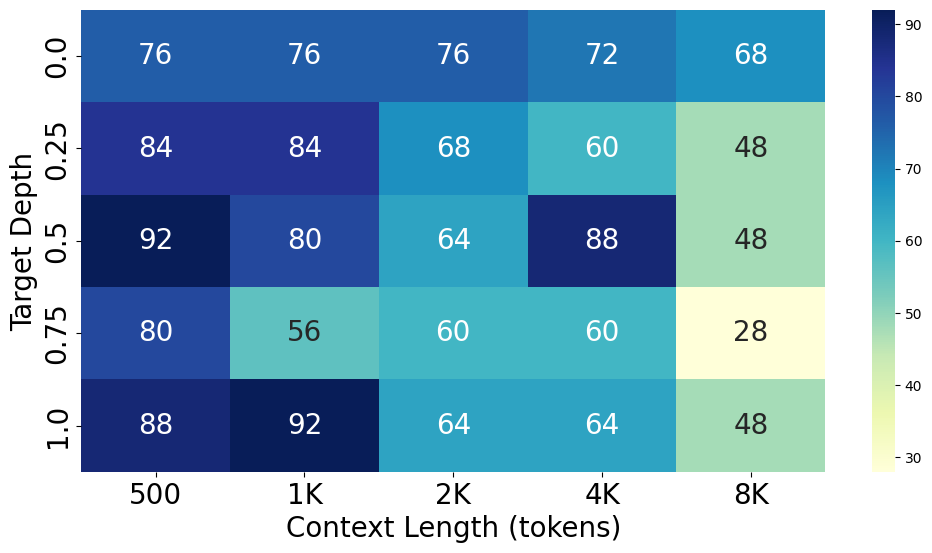

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by target_length and target_depth, calculate the mean of the result column (assuming result is boolean where True=1 and False=0)
accuracy_df = df_single_bug_test_result.groupby(['target_length', 'target_depth']).agg(accuracy=('result', 'mean')).reset_index()

# Pivot the DataFrame to get the desired shape for the heatmap.
pivot_df = accuracy_df.pivot(index='target_depth', columns='target_length', values='accuracy')

# Convert accuracy to percentages.
pivot_df *= 100

# Custom labels for the x-axis
custom_x_labels = ["500", "1K", "2K", "4K", "8K"]  # Customize these labels as needed

# Plot the heatmap.
plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", annot_kws={'size': 20}, cbar_kws={'label': ''})
plt.xlabel('Context Length (tokens)', fontsize=20)
plt.ylabel('Target Depth', fontsize=20)
ax.set_xticklabels(custom_x_labels)  # Set custom labels
plt.tick_params(labelsize=20)
plt.show()